Notebook to train and analyze a Mixture of Experts architecture using label split on the default mnist dataset. 45 experts (10nCr2) are trained, each expert for each pair of two different digits. In a second step a gating network is trained and evaluated on datasets containing all ten digits. The outputs of the experts are inflated using a single fully connected layer with ten neurons for each expert. Therefore, for each expert 30 additional weights (20 input weights + 10 bias) are learned.

In [1]:
import torch
import torchvision
import numpy as np
from models.mnist.mnist_net import MnistNet
from models.mnist.generic_gating_network import GenericGatingNetwork
from models.mnist.gating_network import GatingNetwork
from datasets.mnist_dataset import MNISTDataset
from utils.plot_confusion_matrix import plot_confusion_matrix
from utils.dataset_utils import train_test_split, build_subset
from itertools import combinations
import seaborn as sns
import pandas as pd
from scipy.stats import spearmanr

import matplotlib.pyplot as plt

In [2]:
transformations_mnist_default = torchvision.transforms.Compose([
                torchvision.transforms.Resize((28,28)),
                torchvision.transforms.Grayscale(),
                torchvision.transforms.ToTensor(),
])

In [3]:
torch.manual_seed(42)

device = "cuda:0" if torch.cuda.is_available() else "cpu:0"
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [4]:
# Preparing mnist datasets for all digits
mnist_dataset = MNISTDataset('../../data/default_mnist/training', transform=transformations_mnist_default)
mnist_train, mnist_valid = train_test_split(mnist_dataset, [0.8, 0.2])
mnist_test = MNISTDataset('../../data/default_mnist/testing', transform=transformations_mnist_default)

In [5]:
perm = combinations([i for i in range(10)], 2) 
training_sets = []
validation_sets = []
experts = []

for i, labels in enumerate(perm):
    mnist_train_sub = build_subset(mnist_train, labels)
    mnist_valid_sub = build_subset(mnist_valid, labels)
    training_sets.append(mnist_train_sub)
    validation_sets.append(mnist_valid_sub)

    s = ''
    for label in labels:
        s += str(label)

    expert = MnistNet(classes=list(labels), name='expert_'+s)
    expert.load_state_dict(torch.load('./trained_models/label_split_combinations/expert_' + s + '.pth'))
    # expert.fit(
    #     training_data=training_sets[i],
    #     validation_data=validation_sets[i],
    #     num_epochs=5,
    #     batch_size=128,
    #     device=device,
    #     criterion=criterion,
    #     optimizer=optimizer,
    #     learning_rate=0.0005,
    #     save_state_path='./trained_models/label_split_combinations/expert_' + s + '.pth'
    #     )
    experts.append(expert)

In [6]:
gate = GenericGatingNetwork(classes=[i for i in range(10)], experts=experts)
gate = gate.to(device)
gate.evaluate(mnist_test, 128, criterion, device)

{'loss': 2.4294, 'acc': 0.0893, 'entropy': 3.2691}

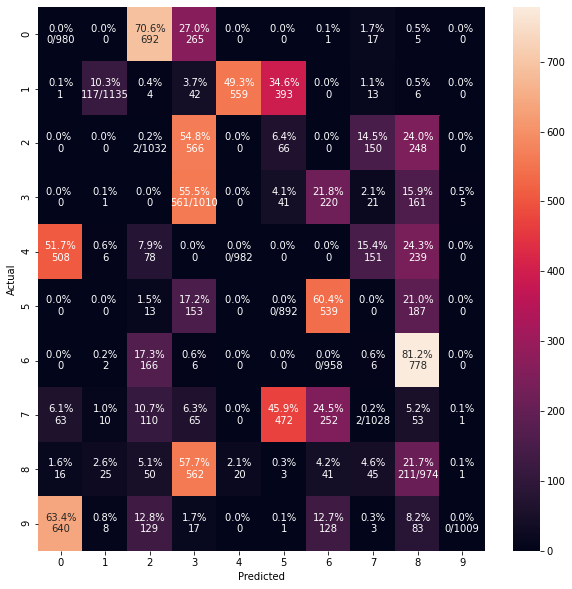

In [7]:
y_pred = gate.predict(mnist_test, device)
y_true = mnist_test.targets
plot_confusion_matrix(y_true, y_pred, [i for i in range(10)])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff870108390>]],
      dtype=object)

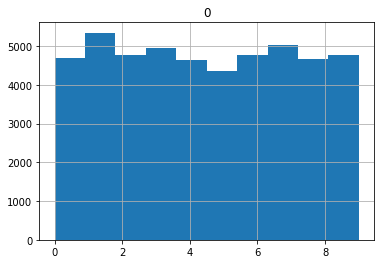

In [8]:
targets = mnist_train.targets
pd.DataFrame(targets).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff8700c4400>]],
      dtype=object)

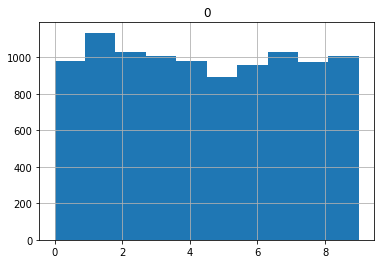

In [9]:
targets = mnist_test.targets
pd.DataFrame(targets).hist()

In [10]:
gate.load_state_dict(torch.load('./trained_models/label_split_combinations/gate_fc.pth'))
# gate.fit(
#     training_data=mnist_train, 
#     validation_data=mnist_valid, 
#     num_epochs=20, 
#     batch_size=128, 
#     device=device, 
#     criterion=criterion, 
#     optimizer=optimizer, 
#     learning_rate=0.0001, 
#     save_state_path='./trained_models/label_split_combinations/gate_fc.pth'
# )

<All keys matched successfully>

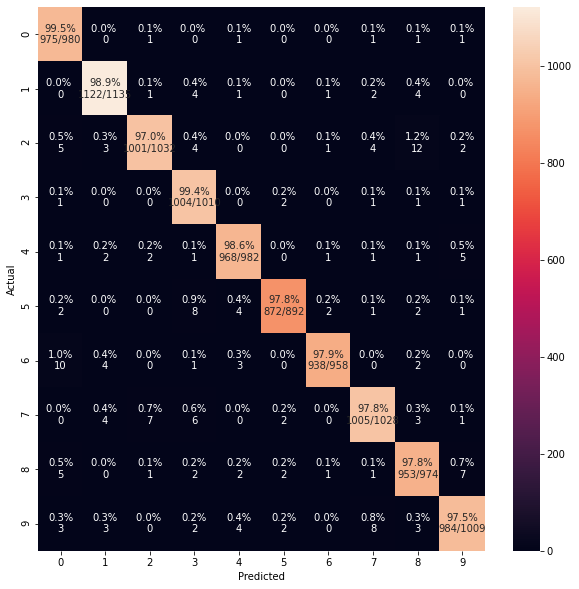

In [11]:
y_pred = gate.predict(mnist_test, device)
y_true = mnist_test.targets
plot_confusion_matrix(y_true, y_pred, [i for i in range(10)])

In [12]:
gate.evaluate(mnist_test, 128, criterion, device)

{'loss': 0.1158, 'acc': 0.9822, 'entropy': 0.1984}

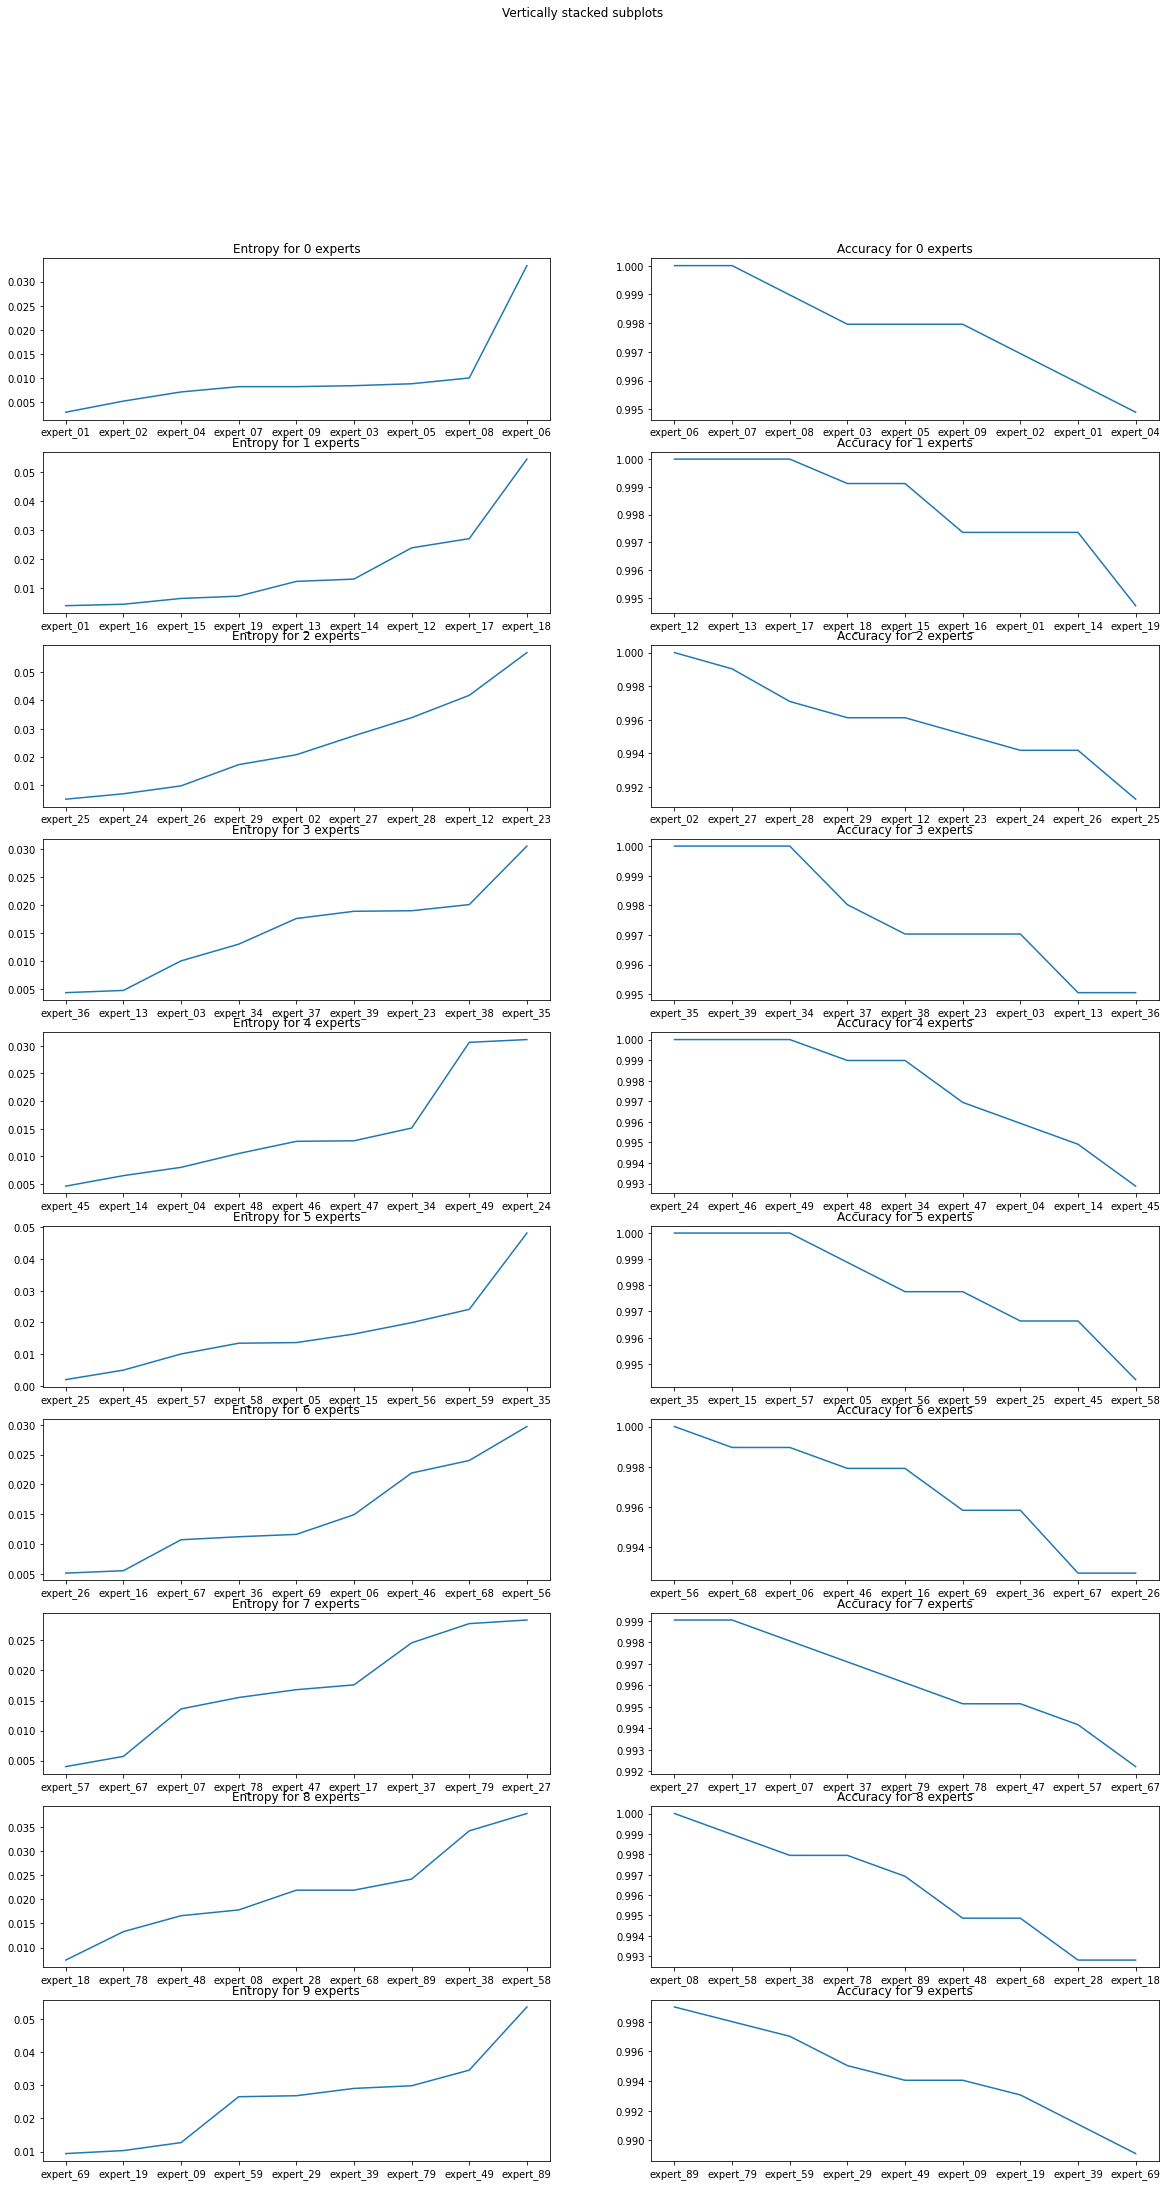

In [13]:
fig, axs = plt.subplots(10, 2, figsize=(20,35))
fig.suptitle('Vertically stacked subplots')

df = pd.DataFrame(columns=['label', 'expert 1', 'weight 1', 'expert 2', 'weight 2', 'expert 3', 'weight 3'])

for i in range(10):
    testset = MNISTDataset('../../data/default_mnist/testing', labels=[i], transform=transformations_mnist_default)
    loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)
    weight_sum = torch.zeros((1, len(gate.experts))).to(device)
    with torch.no_grad():
        for _, (images, labels) in enumerate(loader):
            images = images.to(device)
            weight_sum += torch.sum(gate(images)['weights'], dim=0)
        weight_sum = weight_sum / len(testset)
    
    sorted_indices = torch.argsort(weight_sum, dim=1, descending=True)[0].cpu().numpy()
    exp = gate.experts
    exp_results = []
    
    for e in experts:
        if str(i) in e.name:
            result = e.evaluate(
                test_data=testset,
                batch_size=128,
                criterion=criterion,
                device=device
            )
            exp_results.append(result)

    entr = [x['entropy'] for x in sorted(exp_results, key=lambda x: x['entropy'])[:]]
    names = [x['name'] for x in sorted(exp_results, key=lambda x: x['entropy'])[:]]
    axs[i, 0].plot(names, entr)
    axs[i, 0].set_title('Entropy for ' + str(i) + ' experts')

    acc = [x['acc'] for x in sorted(exp_results, key=lambda x: x['acc'], reverse=True)[:]]
    names = [x['name'] for x in sorted(exp_results, key=lambda x: x['acc'])[:]]
    axs[i, 1].plot(names, acc)
    axs[i, 1].set_title('Accuracy for ' + str(i) + ' experts')

    weight_sum = weight_sum[0] 

    result_dict = dict()
    result_dict['label'] = i
    result_dict['expert 1'] = exp[sorted_indices[0]].name
    result_dict['weight 1'] = weight_sum[sorted_indices[0]].item()
    result_dict['expert 2'] = exp[sorted_indices[1]].name
    result_dict['weight 2'] = weight_sum[sorted_indices[1]].item()
    result_dict['expert 3'] = exp[sorted_indices[2]].name
    result_dict['weight 3'] = weight_sum[sorted_indices[2]].item()
    df = df.append(result_dict, ignore_index=True)

In [14]:
df

,label,expert 1,weight 1,expert 2,weight 2,expert 3,weight 3
0,0,expert_12,0.996141,expert_36,0.001020,expert_68,0.001020
1,1,expert_19,0.982788,expert_13,0.005567,expert_36,0.003960
2,2,expert_29,0.967106,expert_48,0.014055,expert_12,0.004987
3,3,expert_36,0.993870,expert_48,0.001980,expert_18,0.000999
4,4,expert_34,0.984878,expert_69,0.004519,expert_46,0.003013
5,5,expert_18,0.762734,expert_79,0.219372,expert_36,0.008543
6,6,expert_46,0.981391,expert_12,0.009836,expert_36,0.003128
7,7,expert_68,0.980315,expert_29,0.006732,expert_36,0.005595
8,8,expert_48,0.972351,expert_67,0.006254,expert_12,0.005140
9,9,expert_69,0.934498,expert_49,0.041054,expert_68,0.006786
